In this week's tutorial we will look into generative modelling. At the end of this tutorial you should be able to:
- Build a variational auto-encoder
- Use it to generate images
- Understand the effect of the loss on the latent encoding of images

**If possible, use a GPU to train the models, especially for the convolutional VAE which otherwise could take too long to train (if you don't have a GPU you can try to run on Google Colab).**

# Building a variational auto-encoder

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

For this section, we will begin by working on the MNIST dataset.

In [2]:
batch_size = 128

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Let's visualise one of the images in the dataset.

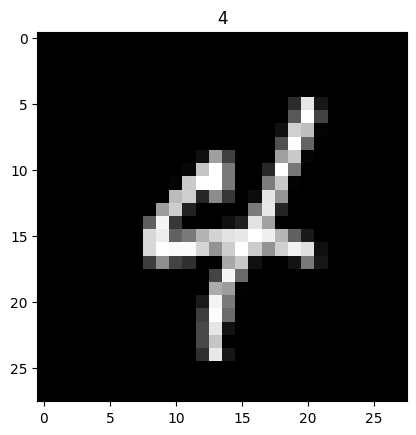

In [3]:
# get some random training images; this will load a set of images of size batchsize
dataiter = iter(trainloader)
images, labels = next(dataiter)
img = images[0] # take just the first image; the above thing is an array of images of size batchsize

# Print the original image
npimg = img.numpy() # translate to numpy
npimg_t = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg_t, cmap='gray')
plt.title(str(classes[labels[0]]))
plt.show()

Let's now define the architecture for the VAE. Let $p^*(\mathbf{x})$ be the true distribution from which images $\mathbf{x}$ are sampled. We want to find an encoding of $\mathbf{x}$ as a latent variable $\mathbf{z}$ (where the dimension of $\mathbf{z}$ is less than the dimension of $\mathbf{x}$) which we will choose to sample from $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$.

Recall from lectures that the model will involve two parts: the encoder network parameterising $q_\psi(\mathbf{z}|\mathbf{x})$ and the decoder network parameterising $p_\phi(\mathbf{x}|\mathbf{z})$.

**Encoder**

We will assume that, for each image $\mathbf{x}$ we input to the encoder, $q_\psi(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\boldsymbol{\mu_x}, \text{diag}(\boldsymbol{\sigma_x}))$. Hence, we define a network which reduces the dimension of the output at each layer and eventually outputs the mean $\boldsymbol{\mu_x}$ and the covariance matrix $\text{diag}(\boldsymbol{\sigma_x})$. We typically assume that the covariance matrix is diagonal and that the outputted $\boldsymbol{\sigma_x}$ is the vector containing the entries of the diagonal instead of parameterising all the elements of the covariance matrix.

**Reparametrisation**

We will then need to sample from $\mathcal{N}(\boldsymbol{\mu_x}, \text{diag}(\boldsymbol{\sigma_x}))$, which we do by $\mathbf{z} = \boldsymbol{\mu_x} + \boldsymbol{\sigma_x} \odot \boldsymbol{\epsilon}$, where $\odot$ denotes element-wise product and $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

**Decoder**

We will define a network which will increase the dimension of the output at each layer and eventually outputs a vector of the same dimensions as the input image $\mathbf{x}$ passed through a sigmoid activation function.

Since the values of the pixels in the MNIST dataset are in the range $[0,1]$ and tend to be binary (close to either $0$ or $1$), we can assume the distribution of the pixel values to be Bernoulli. Hence, we choose
$$p_\phi(\mathbf{x}|\mathbf{z}) =  \prod_{i=1}^D y_i^{x_i}(1-y_i)^{1-x_i},$$
$$\log p_\phi(\mathbf{x}|\mathbf{z}) = \sum_{i=1}^D x_i \log y_i + (1-x_i) \log (1-y_i),$$
where $y_i$ is the output of the decoder and $x_i$ the pixel value of the original image. We will also use the value of $y_i$ as the output image (recall that this is also the mean in a Bernoulli distribution).

Note that we have assumed that the MNIST dataset is binary, when this is not the case, however even with this assumption, models has been shown to produce good quality images, and most models of VAEs working on this dataset have been implemented using this assumption. See https://proceedings.neurips.cc/paper_files/paper/2019/file/f82798ec8909d23e55679ee26bb26437-Paper.pdf for more details and an approach that provides an alternative that is probabilistically coherent.

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, input_dim=784):
        """builds VAE
        Inputs:
            - latent_dim: dimension of latent space
            - input_dim: dimension of input space
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.encoder_mean = nn.Linear(128, latent_dim)
        self.encoder_logvar = nn.Linear(128, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 512)
        self.fc5 = nn.Linear(512, 784)


    def encode(self, x):
        """take an image, and return latent space mean and log variance
        Inputs:
            -x: batch of images flattened to 784
        Outputs:
            -means in latent dimension
            -logvariances in latent dimension
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.encoder_mean(x), self.encoder_logvar(x) # We return mu_x and log(sigma_x)

    def reparametrise(self, mu, logvar):
        """Sample in latent space according to mean and logvariance
        Inputs:
            -mu: batch of means
            -logvar: batch of logvariances
        Outputs:
            -samples: batch of latent samples
        """
        std = torch.exp(0.5 * logvar) # Note that we are working with the the logvariances instead of the variances (this is fine as long as we are consistent throughout the model)
        eps = torch.randn_like(std)
        samples = mu + eps * std
        return samples

    def decode(self, z):
        """Decode latent space samples
        Inputs:
            -z: batch of latent samples
        Outputs:
            -x_recon: batch of reconstructed images
        """
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        raw_out = self.fc5(z)
        x_recon =  torch.sigmoid(raw_out) # Apply sigmoid activation function which ensures output has values in [0,1]
        return x_recon

    def forward(self, x):
        """Do full encode and decode of images
        Inputs:
            - x: batch of images
        Outputs:
            - self.decode(z): batch of reconstructed images
            - mu: batch of latent mean values
            - logvar: batch of latent logvariances
        """
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrise(mu, logvar)
        return self.decode(z), mu, logvar

**Loss**

The loss of a VAE, also known as the ELBO loss, is given by
$$
\mathcal{L}(\mathbf{x}, \phi, \psi) = KL(q_\psi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z})) - \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z}).
$$

We chose $q_\psi(\mathbf{z}|\mathbf{x})$ and $p(\mathbf{z})$ to be Gaussians, so the KL divergence can be computed in close form as
$$
KL(q_{\psi}(\mathbf{z}|\mathbf{x})||p(\mathbf{z})) = \frac{1}{2}\left(-\sum_{j=1}^J\log \sigma_j^2 - J + \sum_{j=1}^J \sigma_j^2 + \sum_{j=1}^J\mu_j^2\right).
$$

Taking a Monte-Carlo estimate of the expectation with one sample, we can write the remaining term as
$$
-\log p_\phi(\mathbf{x}|\mathbf{z}) = - \sum_{i=1}^D x_i \log y_i + (1-x_i) \log (1-y_i).
$$
This last term is the binary cross entropy loss.

In [5]:
def ELBO_loss(x, reconstructed_x, mu, logvar):
    '''
    calculates ELBO loss
    Inputs:
        - x: batch of images
        - reconstructed_x: batch of reconstructed images
        - mu: batch of latent mean values
        - logvar: batch of latent logvariances
    Outputs:
        - neg_loglikelihood: average value of negative log-likelihood term across batch
        - KL_divergence: average value of KL divergence term across batch
        - loss: average ELBO loss across batch
    '''
    neg_loglikelihood = F.binary_cross_entropy(reconstructed_x, x.view(-1,784), reduction='sum').div(x.size(0)) # Cross-entropy between outputted image and (flattened) original image
    KL_divergence = torch.mean(0.5 * (torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar, dim=1)), dim=0) # KL divergence term (note we use the logvariances instead of the variances)
    loss = neg_loglikelihood + KL_divergence
    return neg_loglikelihood, KL_divergence, loss

Let's write a training function:

In [10]:
def train(model, nr_epochs, optimizer, criterion, dataloader=trainloader, has_labels=True, loss_modification=None):
    # use gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(nr_epochs):
        # iterate through batches
        for i, data in enumerate(dataloader, 0):

            # get inputs
            if has_labels==True:
                # get the inputs if data is a list of [inputs, labels]
                images, labels = data
            else:
                images = data

            # gpu
            if torch.cuda.is_available():
                images = images.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # Compute the output for all the images in the batch_size; remember we set a batch_size of 10 in the beginning!
            reconstructed_images, mu, logvar = model(images)
            # Compute the loss value
            neg_loglikelihood, KL_divergence, loss = criterion(images, reconstructed_images, mu, logvar)
            # Compute the gradients
            if loss_modification == 'neg_loglikelihood': #these will be used in the tasks below
                neg_loglikelihood.backward()
            elif loss_modification == 'kl_div': #these will be used in the tasks below
                KL_divergence.backward()
            else:
              loss.backward()
            # Take the optimisation step
            optimizer.step()

        # print results for last batch
        print(f'Epoch: {epoch:03} | ELBO loss: {loss} | KL divergence: {KL_divergence} | Negative log-likelihood: {neg_loglikelihood}')

    model.to('cpu')
    print('Finished Training')

In [11]:
vae = VAE()
train(model=vae, nr_epochs=20, optimizer=torch.optim.Adam(vae.parameters(), lr=0.001), criterion=ELBO_loss)

Epoch: 000 | ELBO loss: 169.72003173828125 | KL divergence: 4.8998637199401855 | Negative log-likelihood: 164.82017517089844
Epoch: 001 | ELBO loss: 155.1441650390625 | KL divergence: 5.751033306121826 | Negative log-likelihood: 149.39312744140625


KeyboardInterrupt: 

Let's now sample some images from our trained model.

In [ ]:
def sample_images(model, num_im):
    '''
    Inputs:
        - model: trained vae
        - num_im: int, number of images to sample
    '''
    # sample latent variables
    latent = torch.randn(num_im, model.latent_dim)
    # pass latent variables through the decoder
    output = model.decode(latent)
    # reshape output of model into 28x28
    images = output.view(-1, 28, 28)

    # plot images
    fig, ax = plt.subplots(nrows=1, ncols=num_im)
    for i in range(num_im):
        image = images[i]
        ax[i].imshow(image.detach().numpy(), cmap='gray')
        ax[i].axis('off')

    plt.show()

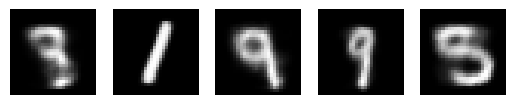

In [ ]:
sample_images(vae, 5)

Run this code multiple times to see different sampled images. Note that some of the numbers generated are not easily identifiable or seem to combine more than one handwritten number.

Feel free to change the architecture (e.g. number of layers, latent dimension), batch size, number of epochs to see how this changes the model and convergence of the loss.

# Exploring the latent space

Let's try to visualise what is going on in the latent space. In this case, we have used a 2-dimensional latent space, so we can visualise on a plane the outputs we would get by varying the values of the variables that make up the latent vector.

Let $\mathbf{z} = (x, y)$ be a latent variable and consider a possible range of values for $x$ and $y$ that we want to study. We can discretise the intervals of these ranges of values to obtain a mesh of points on the latent space. For each point $(x_i, y_j)$ on the mesh we can then apply the decoder and visualise the resulting image at the corresponding location on the plane.

In [ ]:
def plot_reconstructed(model, range_x, range_y, n=16):
    '''
    Inputs:
    model: trained vae
    range_x: tuple, range of values of first latent dimension
    range_y: tuple, range of values of second latent dimension
    n: number of images to plot along each axis
    '''
    w = 28 # height and width of output image
    img = np.zeros((n*w, n*w)) # the total number of pixels for n images of size 28x28 will be n*28xn*28 pixels

    # plot images in latent space
    for i, y in enumerate(np.linspace(*range_y, n)):
        for j, x in enumerate(np.linspace(*range_x, n)):
            z = torch.Tensor([[x, y]])
            x_sample = model.decode(z)
            x_sample = x_sample.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_sample
    plt.imshow(img, extent=[*range_x, *range_y], cmap='gray')

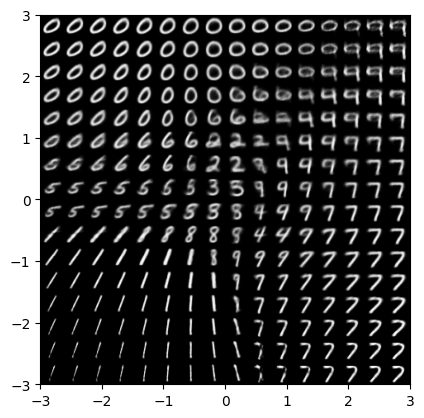

In [ ]:
plot_reconstructed(vae, range_x=(-3, 3), range_y=(-3, 3))

Notice how there are regions on the plane where we can easily identify the number that we would obtain if we sampled from that region, and there are areas in the boundary between regions that are more ambiguous or combine numbers.

**Exercise:** vary the limits of range_x and range_y in the above function to explore the outputs of the vAE. What do you notice happens as we get close to the origin? What about as we get further away from origin?

We can also visualise where on the latent space is the latent representation of each training image. Images from the same class (which hence will be similar and have similar characteristics) will tend to have a similar encoding $\boldsymbol{\mu_x}$ and $\boldsymbol{\sigma_x}$.

Let's take every image $\mathbf{x}$ from the training set, sample a corresponding $\mathbf{z}$ from $\mathcal{N}(\boldsymbol{\mu_x}, \boldsymbol{\sigma_x})$ and plot $\mathbf{z}$ on the plane.

In [ ]:
def plot_latent(model):
    for batch in trainloader:
        # get images and labels in batch
        x, labels = batch
        # pass images through the vae encoder
        mu, logvar = model.encode(x.view(-1, 784))
        # sample a latent z for each image
        z = model.reparametrise(mu, logvar)
        z = z.detach().numpy() # convert to numpy array
        # plot z values
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
    plt.legend(*scatter.legend_elements(), title="Label")

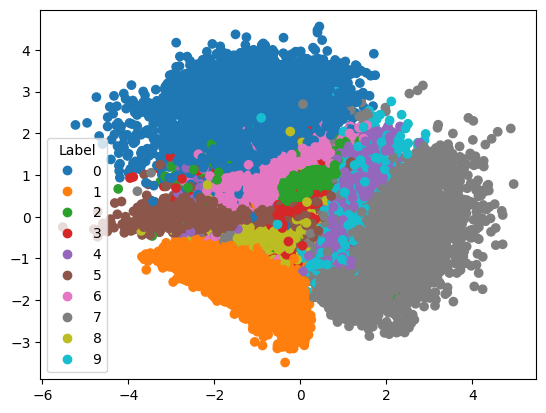

In [ ]:
plot_latent(vae)

Notice that:

1.   All training images are encoded close to the origin
2.   Training images from the same class seem to form clusters on the latent space
3.   The location of the latent encoding of each class label roughly matches the region in the latent space from which we obtained that label when generating samples in the previous plot



# Understanding the effect of the loss on the latent encodings

Recall that the loss was defined as
$$
\mathcal{L}(\mathbf{x}, \phi, \psi) = KL(q_\psi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z})) - \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z}).
$$

In this section we aim to explore empirically how each term $KL(q_\psi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}))$ and $- \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z})$ affects the latent space and the encoding/decoding ability of the model. We will approach this by training on each of the terms in the loss separately.

Note that although we may refer to the models we obtain as VAEs, they will technically **not be variational autoencoders** (even if they follow their architecture), as the definition of VAEs includes using the ELBO loss to train them.

## Task: train a model using $- \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z})$ as the loss

You may want to either modify the train function or write a different loss function to input as criterion.

In [ ]:
vae2 = VAE()
train(model=vae2, nr_epochs=20, optimizer=torch.optim.Adam(vae2.parameters(), lr=0.001), criterion=ELBO_loss, loss_modification='neg_loglikelihood')

Epoch: 000 | ELBO loss: 188.48257446289062 | KL divergence: 39.46999740600586 | Negative log-likelihood: 149.0125732421875
Epoch: 001 | ELBO loss: 199.00331115722656 | KL divergence: 52.82177734375 | Negative log-likelihood: 146.18153381347656
Epoch: 002 | ELBO loss: 205.39352416992188 | KL divergence: 60.59408950805664 | Negative log-likelihood: 144.7994384765625
Epoch: 003 | ELBO loss: 196.66375732421875 | KL divergence: 49.47990036010742 | Negative log-likelihood: 147.18385314941406
Epoch: 004 | ELBO loss: 195.22042846679688 | KL divergence: 57.60160827636719 | Negative log-likelihood: 137.6188201904297
Epoch: 005 | ELBO loss: 208.918701171875 | KL divergence: 70.92097473144531 | Negative log-likelihood: 137.9977264404297
Epoch: 006 | ELBO loss: 199.5744171142578 | KL divergence: 54.571598052978516 | Negative log-likelihood: 145.00282287597656
Epoch: 007 | ELBO loss: 203.12548828125 | KL divergence: 64.42223358154297 | Negative log-likelihood: 138.70326232910156
Epoch: 008 | ELBO lo

After training, use the plot_latent function to visualise the encodings of the training set. How does the plot differ from what we observed previously?

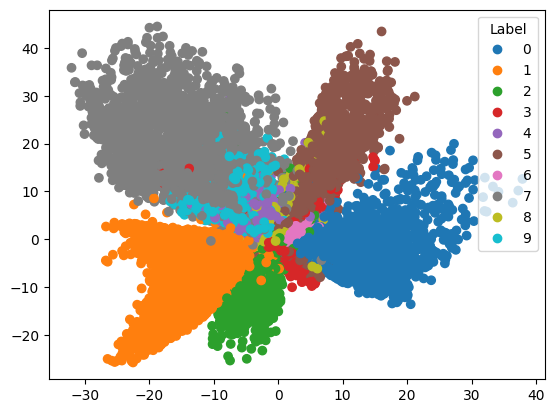

In [ ]:
plot_latent(vae2)

*In the above plot we can see that the clusters of each number are more spread out than in the VAE trained on the ELBO loss.*

Let's try sampling some images. What do you observe? Can you generate all numbers?

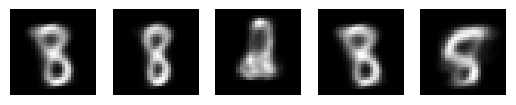

In [ ]:
sample_images(vae2, 5)

*Trying to sample images, in this case it is rare to generate 0's. This will vary with the trained model and the latent representations learnt, but it is likely that it is hard to sample at least one class of numbers from $p(\mathbf{z})$.*

You can also use the plot_reconstructed function to visualise the outputs. Feel free to play around with the ranges for $x$ and $y$.

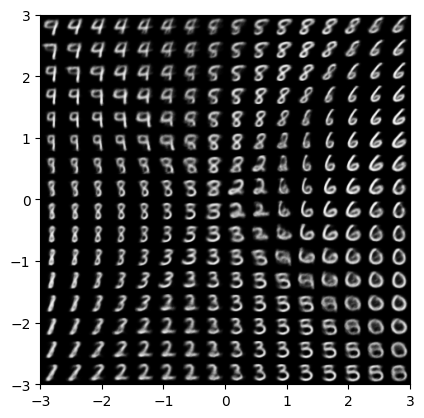

In [ ]:
plot_reconstructed(vae2, range_x=(-3, 3), range_y=(-3, 3))

## Task: train a model using $KL(q_\psi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}))$ as the loss

Similar to the previous task, now train a VAE only on the KL-divergence term of the loss. As before, you may want to modify the train function or write a new loss function.

In [ ]:
vae3 = VAE()
train(model=vae3, nr_epochs=10, optimizer=torch.optim.Adam(vae3.parameters(), lr=0.001), criterion=ELBO_loss, loss_modification='kl_div')

Epoch: 000 | ELBO loss: 544.886962890625 | KL divergence: 3.857256615447113e-06 | Negative log-likelihood: 544.886962890625
Epoch: 001 | ELBO loss: 545.2745361328125 | KL divergence: 2.100355459333514e-06 | Negative log-likelihood: 545.2745361328125
Epoch: 002 | ELBO loss: 545.0275268554688 | KL divergence: 1.0459189070388675e-06 | Negative log-likelihood: 545.0275268554688
Epoch: 003 | ELBO loss: 544.908447265625 | KL divergence: 8.960681157077488e-07 | Negative log-likelihood: 544.908447265625
Epoch: 004 | ELBO loss: 545.243896484375 | KL divergence: 3.766229781376751e-07 | Negative log-likelihood: 545.243896484375
Epoch: 005 | ELBO loss: 544.9840087890625 | KL divergence: 5.612479867522779e-07 | Negative log-likelihood: 544.9840087890625
Epoch: 006 | ELBO loss: 544.9955444335938 | KL divergence: 3.95540467934552e-07 | Negative log-likelihood: 544.9955444335938
Epoch: 007 | ELBO loss: 545.0673217773438 | KL divergence: 4.577450454235077e-07 | Negative log-likelihood: 545.067321777343

Again, use the plot_latent function to visualise the encodings of the training set. How is this plot different to what you have previously observed?

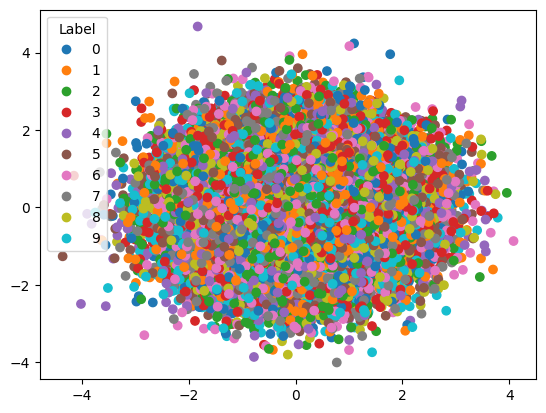

In [ ]:
plot_latent(vae3)

*In this case there are no clusters of images. All training images have encodings plotted on the latent space that show no clear patterns between classes. The decoder is unable to find anything meaningful in the images because there isn't anything meaningful on the latent space.*

Try sampling new images. Is the model capable of decoding anything meaningful from the latent space?

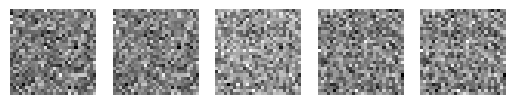

In [ ]:
sample_images(vae3, 5)

## Conclusions

Based on the observations from the previous tasks, can you explain how each term in the ELBO loss contributes to shaping the latent space?

*The negative log-likelihood term in the loss ensures that the model learns meaningful representations of the images. However, if we only train using this term, the encodings of the different classes are very widely distributed across the latent space, and sampling from $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is not effective, as a lot of images have latent representations far from the origin. This means that information of the characteristics of certain images is encoded far away from the origin, and if we sample from a standard Gaussian it is very unlikely that we will sample anything on the latent space from those areas.*

*The KL divergence term in the loss ensures that for each image $\mathbf{x}$, $q_\psi(\mathbf{z}|\mathbf{x})$ is close to our chosen prior $p(\mathbf{z})=\mathcal{N}(\mathbf{0}, \mathbf{I})$. When only training using this term, the latent representations are sampled according to distributions very close to a standard Gaussian, because the model is only minimising the KL divergence (which can be interpreted as a distance) between the encoder distribution and a standard Gaussian.*

*When training using both terms together, the model is learning latent distributions of the training set that are meaningful and are also close to $p(\mathbf{z})$.*

# Convolutional variational auto-encoder



We will now look at implementing a convolutional variational autoencoder. We will work with a dataset of images containing 2 non-overlapping randomly coloured dots. The images are of size $64 \times 64$ (with 3 channels).

In [ ]:
from torch.utils.data import Dataset
import os

class DotsDataset(Dataset):
    def __init__(self, db_path, noisy=True):
        self.db_path = db_path
        self.db_files = [os.listdir(path) for path in db_path]
        self.noisy = noisy
        self.images = None

    def load_data(self):
        images_list = []
        # iterate through paths in input list
        for path in self.db_path:
            # iterate through files in path
            for file in self.db_files[self.db_path.index(path)]:
                filename_path = os.path.join(path, file)
                # load images
                img = np.load(filename_path)['images']
                # noise
                if self.noisy:
                    img += np.random.normal(loc=0, scale=0.03, size=img.shape)
                    img = 1.0 - np.abs(1.0 - img)
                    img = np.abs(img)
                # append images to list
                images_list.append(img)
        # convert to tensor and adjust dimensions
        image_tensor = torch.from_numpy(np.concatenate(images_list, axis=0))
        self.images = torch.movedim(image_tensor, 3, 1)

    def __len__(self):
        if self.images is None:
            self.load_data()
        return len(self.images)

    def __getitem__(self, idx):
        if self.images is None:
            self.load_data()
        image = self.images[idx]
        return image

Let's load the dataset. Make sure you have the 2_dots folder in your directory before running this code.

In [ ]:
train_set_dots = DotsDataset(db_path=['./2_dots'], noisy=False)
print('Size of dataset:',train_set_dots.__len__())

trainloader_dots = torch.utils.data.DataLoader(train_set_dots, batch_size=128, shuffle=True, num_workers=2)

Size of dataset: 49152


Note: if you are using Google Colab and you get an error when loading the dataset related to ./2_dots/.ipynb_checkpoints uncomment and run this cell and then try again:

In [ ]:
#rmdir ./2_dots/.ipynb_checkpoints

We can visualise one of the images in the dataset.

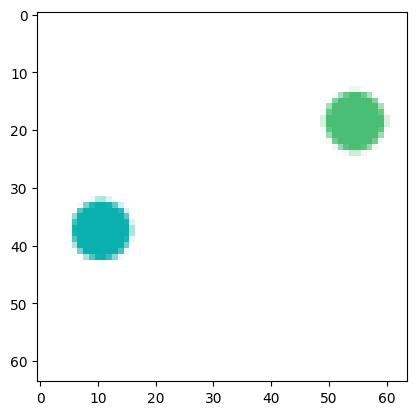

In [ ]:
# get some random training images; this will load a set of images of size batchsize
dataiter = iter(trainloader_dots)
images = next(dataiter)
img = images[0] # take just the first image; the above thing is an array of images of size batchsize

# Print the original image
npimg = img.numpy() # translate to numpy
npimg_t = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg_t)
plt.show()

We will now train a convolutional variational autoencoder on the 2_dots dataset. The structure of the network will be the same as for the MNIST dataset with the additional use of convolutional layers. However, the decoder network will be slightly different.

**Decoder**

We previosly assumed that we could model $p_\phi(\mathbf{x}|\mathbf{z})$ using a Bernoulli distribution. However, in this case the pixels in general will not take only two possible values, so instead we will assume a Gaussian distribution.

$$
p_{\phi}(\mathbf{x}|\mathbf{z}) = \left(2\pi\right)^{-D/2}det(\Sigma)^{-1/2}\exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma(\mathbf{x}-\boldsymbol{\mu})\right)
$$

We would then need (in a similar manner as with the encoder) to output a mean and covariance for each latent variable $\mathbf{z}$ passed through the decoder. However, we typically assume the covariance matrix is the identity matrix (and hence don't parameterise it). In order to calculate the term $- \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z})$ from the loss, we can then take a Monte Carlo approximation of the expectation - this is typically done with only one sample, (typically chosen to be the outputted mean $\boldsymbol{\mu}$ instead of randomly sampling from $\mathcal{N}(\boldsymbol{\mu}, \mathbf{I})$).

Hence, $- \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z}) \propto - \|\mathbf{x} - \boldsymbol{\mu}\|^2$. As this term is comparing the difference between the output $\boldsymbol{\mu}$ of the decoder and the original image $\mathbf{x}$, this term is also known as the reconstruction loss. In practice, most models implement $- \mathbb{E}_{\mathbf{z} \sim q_\psi(\mathbf{z}|\mathbf{x})} \log p_\phi(\mathbf{x}|\mathbf{z})$ as $\|\mathbf{x} - \boldsymbol{\mu}\|^2$ (e.g. by using F.mse_loss), ignoring any constants that would scale the term.

Let's define the ELBO loss for the images under our new assumptions.

In [ ]:
def ELBO_loss_Gaussian(x, reconstructed_x, mu, logvar):
    '''
    calculates ELBO loss when p(x|z) is assumed to be Gaussian
    Inputs:
        - x: batch of images
        - reconstructed_x: batch of reconstructed images
        - mu: batch of latent mean values
        - logvar: batch of latent logvariances
    Outputs:
        - neg_loglikelihood: average value of negative log-likelihood term across batch
        - KL_divergence: average value of KL divergence term across batch
        - loss: average ELBO loss across batch
    '''
    neg_loglikelihood = F.mse_loss(reconstructed_x, x, reduction='sum').div(x.size(0)) # Compare the outputted image with the (flattened) original image
    KL_divergence = torch.mean(0.5 * (torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar, dim=1)), dim=0) # KL divergence term (note we use the logvariances instead of the variances)
    loss = neg_loglikelihood + KL_divergence
    return neg_loglikelihood, KL_divergence, loss

**Transpose convolutions**

In order to upscale the images when passed through the decoder, we need to upscale the inputs that we get after downscaling in the encoder with convolutional layers (nn.Conv2d) has on an input. The operator used for this is a transposed convolutional operator (see https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). See https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md for a visualisation of how convolutional layers and transposed convolutional layers are applied.

Note that this is not exaclty a deconvolutional layer (i.e. it is not the inverse of a convolutional layer). The inputs to nn.ConvTranspose2d are the same as in a convolutional layer:

*   in_channels: number of input channels
*   out_channels: number of output channels
*   kernel_size: size of the filter
*   stride: number of rows/columns traversed every time the filter is applied
*   padding: size of extra pixels added at edge of image

As with convolutional layers, it is useful to keep track of the dimension of the outputs after each transposed convolution is applied. Assuming we are working with square inputs, let us define the following:

Let us define the following:

*   $n_{in}$: height (or width) of input image
*   $k$: size of kernel
*   $p$: size of padding
*   $s$: size of stride

The height of the output image will be given by:
$$
n_{out} = (n_{in} - 1)s - 2p + k
$$

## Task : build a convolutional variational autoencoder

Choose the architecture of the encoder and decoder of the VAE. You may choose the number of layers, arguments inputted to the convolutional layers (kernel size, stride, padding), activation function, ... The layers should be added inside the nn.Sequential (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) in the encoder and decoder in the build_VAE function. The encoder should contain some convolutional layers, followed by linear layers. The decoder should contain some linear layers, followed by transposed convolution layers.

Tips:
*   Keep track of the dimension of the output after each layer
*   Don't make your model too large to avoid taking too long to train - you should be able to obtain some results with no more than 4 convolutional layers, 3 linear layers in the encoder (and a similar number for the decoder with transposed convolutions instead)


In [ ]:
# We will use nn.Sequential to build the encoders and decoders - we will use the View class to resize the images
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size) # used to resize tensor to self.size


class CVAE(nn.Module):
    def __init__(self, d=20):
        """builds VAE
        Inputs:
            - d: dimension of latent space
        """
        super(CVAE, self).__init__()
        self.d = d
        # Build VAE here
        self.encoder, self.decoder, self.encoder_mean, self.encoder_lv = self.build_VAE(d)

    def build_VAE(self, d):
        """builds VAE with specified latent dimension and number of layers
        Inputs:
            -d: latent dimension
        """

        encoder = nn.Sequential(
            # Convolutional layers - args: in_channels, out_channels, kernel_size, stride, padding
            nn.Conv2d(3, 32, 4, 2, 1), # size after convolution 32x32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), # size after convolution 16x16
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), # size after convolution 8x8
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), # size after convolution 4x4
            nn.ReLU(True),
            # Flatten images: 4x4x32=512
            nn.Flatten(start_dim=1),
            # Linear layers
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True)
        )

        encoder_mean = nn.Linear(256, d)
        encoder_lv = nn.Linear(256, d)

        decoder = nn.Sequential(
            # Linear layers
            nn.Linear(d, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            # Reshape images
            View((-1, 32, 4, 4)), # 32 channels and images size 4x4
            # Transposed convolution layers - args: in_channels, out_channels, kernel_size, stride, padding
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # size after transposed convolution 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # size after transposed convolution 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # size after transposed convolution 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1) # size after transposed convolution 64x64
        )

        return encoder, decoder, encoder_mean, encoder_lv

    def encode(self, x):
        """take an image, and return latent space mean + log variance
        Inputs:
            -images, x
        Outputs:
            -means in latent dimension
            -logvariances in latent dimension
        """
        h1 = self.encoder(x)
        return self.encoder_mean(h1), self.encoder_lv(h1)

    def reparametrise(self, mu, logvar):
        """Sample in latent space according to mean and logvariance
        Inputs:
            -mu: batch of means
            -logvar: batch of logvariances
        Outputs:
            -samples: batch of latent samples
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        samples = mu + eps * std
        return samples

    def decode(self, z):
        """Decode latent space samples
        Inputs:
            -z: batch of latent samples
        Outputs:
            -x_recon: batch of reconstructed images
        """
        raw_out = self.decoder(z)
        x_recon = torch.sigmoid(raw_out) # pass raw output through sigmoid activation function
        return x_recon

    def forward(self, x):
        """Do full encode and decode of images
        Inputs:
            - x: batch of images
        Outputs:
            - batch of reconstructed images
            - mu: batch of latent mean values
            - logvar: batch of latent logvariances
        """
        mu, logvar = self.encode(x)
        z = self.reparametrise(mu, logvar)
        return self.decode(z), mu, logvar

Now train your model. It can sometimes be hard to find the right hyperparameters for this. There are some suggested parameters for training with Adam in the cell below, but these will have to be adjusted to your model, so feel free to change them or even change the optimizer used. Also adjust the number of epochs appropriately. See if you can get the ELBO loss below 50, but if the model is taking too long to train you can still use it to sample some images and look at what the model has learnt.

Tips:
*   If during training the KL divergence is very small ($\approx \times 10^{-7}$) and does not increase, try increasing your learning rate
*   Use an optimiser with an adaptive learning rate (e.g. Adam)
*   Use a GPU



In [ ]:
conv_vae = CVAE()
train(model=conv_vae, nr_epochs=100, optimizer=torch.optim.Adam(conv_vae.parameters(), lr=0.0006, betas=(0.4, 0.9)), criterion=ELBO_loss_Gaussian, dataloader=trainloader_dots, has_labels=False)

Epoch: 000 | ELBO loss: 166.71859741210938 | KL divergence: 0.0011281504994258285 | Negative log-likelihood: 166.71746826171875
Epoch: 001 | ELBO loss: 155.68881225585938 | KL divergence: 2.823716402053833 | Negative log-likelihood: 152.86509704589844
Epoch: 002 | ELBO loss: 134.2850341796875 | KL divergence: 11.143930435180664 | Negative log-likelihood: 123.14109802246094
Epoch: 003 | ELBO loss: 111.47541809082031 | KL divergence: 13.039680480957031 | Negative log-likelihood: 98.43573760986328
Epoch: 004 | ELBO loss: 89.08024597167969 | KL divergence: 18.952547073364258 | Negative log-likelihood: 70.12770080566406
Epoch: 005 | ELBO loss: 84.31575775146484 | KL divergence: 17.408655166625977 | Negative log-likelihood: 66.9071044921875
Epoch: 006 | ELBO loss: 77.83323669433594 | KL divergence: 20.09869956970215 | Negative log-likelihood: 57.734535217285156
Epoch: 007 | ELBO loss: 69.1143798828125 | KL divergence: 19.29817771911621 | Negative log-likelihood: 49.816200256347656
Epoch: 008

Let's now sample some images from the VAE.

In [ ]:
def sample_dots(model, num_im):
    '''
    Inputs:
        - model: trained vae
        - num_im: int, number of images to sample
    '''
    # Fill in steps
    # get latent dimension of model
    d_latent = model.d
    # sample latent vectors from p(z)
    latent = torch.randn(num_im, d_latent)
    # adjust dimensions to plot
    output = torch.movedim(model.decode(latent), 1, 3)

    fig, ax = plt.subplots(nrows=1, ncols=num_im, figsize=(48, 6))

    for i in range(num_im):
        image = output[i]
        ax[i].imshow(image.detach().numpy())
        #ax[i].axis('off')

    plt.show()

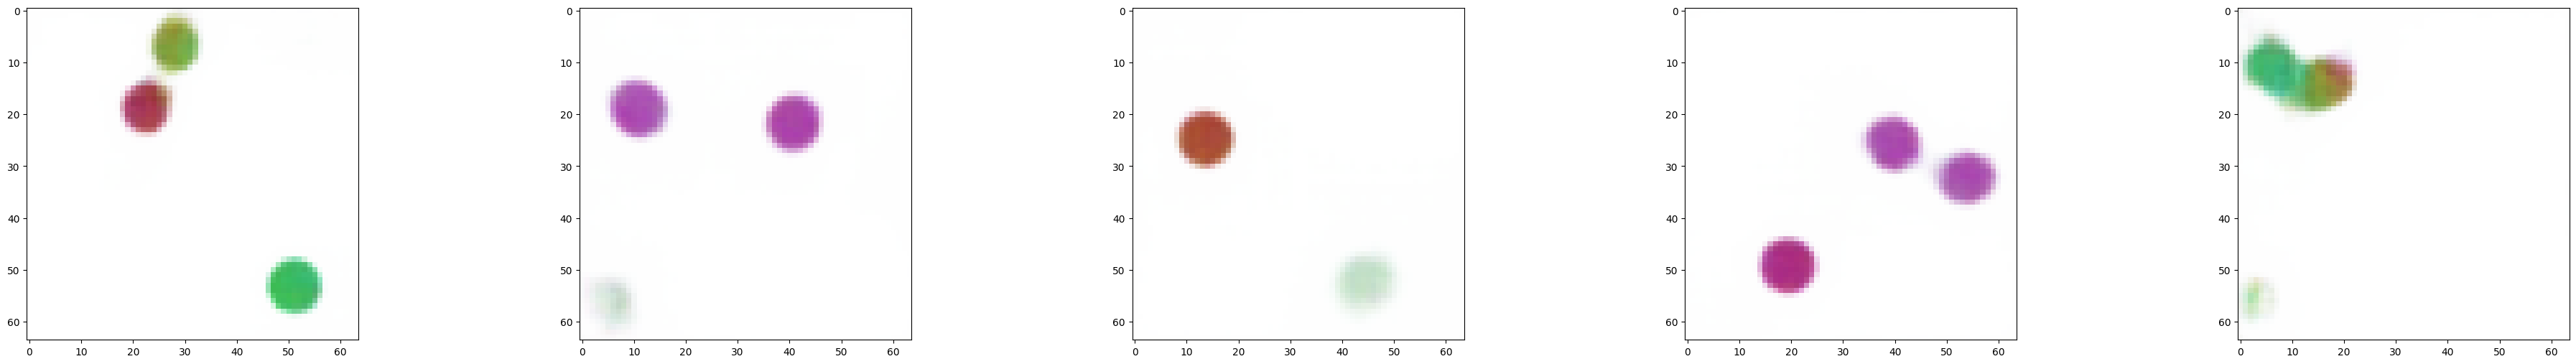

In [ ]:
sample_dots(conv_vae, 5)

# References



*   Diederik P Kingma and Max Welling (2013). Auto-Encoding Variational Bayes. Arxiv: https://arxiv.org/pdf/1312.6114.pdf
*   Gabriel Loaiza-Ganem and John P. Cunningham (2019). The continuous Bernoulli: fixing a pervasive error in
variational autoencoders. Arxiv: https://arxiv.org/pdf/1512.03385.pdf
*   https://lilianweng.github.io/posts/2018-08-12-vae/
*   https://www.tensorflow.org/tutorials/generative/cvae
*   https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


